https://www.kaggle.com/competitions/playground-series-s4e10/data?select=test.csv

Other sources
- https://www.kaggle.com/code/ravi20076/playgrounds4e10-imports-v1
- https://www.kaggle.com/code/halstonlim/playgrounds4e10-baseline-v1/edit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape, test.shape

((58645, 13), (39098, 12))

### EDA

In [3]:
ignore_cols = ['id']

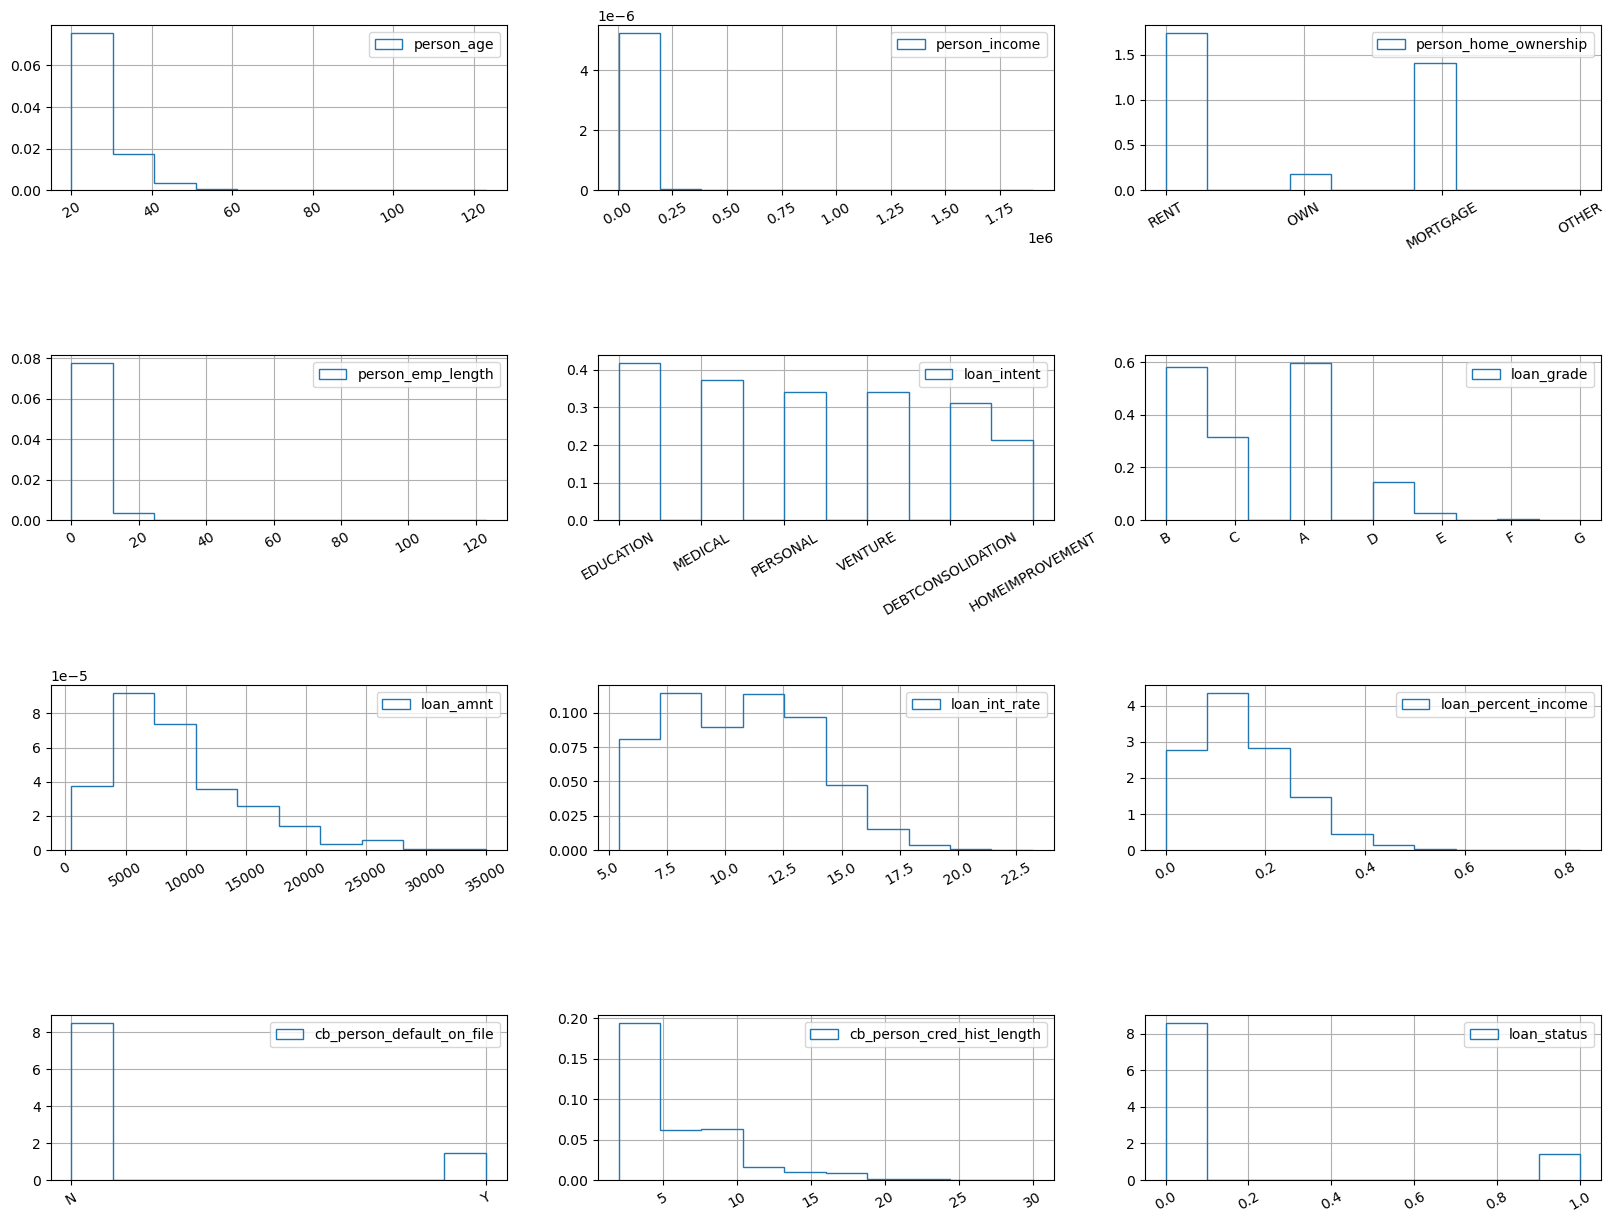

In [4]:
plotcols = [c for c in train.columns if c not in ignore_cols]
ncols = len(plotcols)

nplotrows = (ncols+2) // 3

fig, ax = plt.subplots(nplotrows,3,figsize=(20,15))
fig.subplots_adjust(hspace=1)
axf = ax.flatten()

for i,axi in enumerate(ax.flatten()):
    if i < ncols:
        _,bins,_ = axi.hist(train[plotcols[i]],histtype='step',density=True,label=plotcols[i])
        axi.grid()
        axi.legend()
        axi.tick_params(axis='x', labelrotation=30)
# plt.hist(test[c],bins,density=True);

Investigate data anomalies and create custom columns as needed
- Column `loan_percent_income` is not always correct and off by a factor of 0.01 or 100. Do we need both columns?
- Employment length anomalies

In [5]:
df = train.copy()

In [6]:
df['loan_percent_income_calc'] = df.loan_amnt / df.person_income
# df[['loan_percent_income_calc','loan_percent_income']]
# (df.loan_percent_income_calc - df.loan_percent_income).sort_values()
df.loc[(df.loan_percent_income_calc - df.loan_percent_income).sort_values().tail().index].T

,39716,35437,53756,40121,42205
id,39716,35437,53756,40121,42205
person_age,25,21,21,24,23
person_income,4200,12000,13200,9600,9600
person_home_ownership,RENT,OWN,OWN,RENT,RENT
person_emp_length,5.0,0.0,2.0,0.0,5.0
loan_intent,MEDICAL,EDUCATION,EDUCATION,DEBTCONSOLIDATION,MEDICAL
loan_grade,A,A,D,E,B
loan_amnt,5000,15000,25000,25000,30000
loan_int_rate,6.76,6.99,16.77,17.56,12.42
loan_percent_income,0.12,0.12,0.19,0.25,0.31


In [7]:
df['person_emp_length_calc'] = np.select([df.person_emp_length > 100],[df.person_emp_length.mean()],df.person_emp_length)
df[['person_emp_length','person_emp_length_calc']].sort_values('person_emp_length').tail()

,person_emp_length,person_emp_length_calc
50559,39.0,39.000000
26125,41.0,41.000000
9997,41.0,41.000000
41079,123.0,4.701015
49252,123.0,4.701015


In [8]:
df.groupby([pd.qcut(df.person_income,5),
            pd.qcut(df.loan_amnt,5)],observed=True)[['loan_status']].mean().unstack().style.background_gradient()

In [9]:
df.groupby([pd.cut(df.person_age,bins=[0,22,25,30,35,50]),
            df.loan_intent],observed=True)[['loan_status']].mean().unstack().style.background_gradient()

In [10]:
df.groupby([pd.cut(df.person_age,bins=[0,21,25,30,35,50]),
            df.cb_person_default_on_file],observed=True)[['loan_status']].mean().unstack().style.background_gradient()

In [11]:
(df.groupby([
    pd.cut(df.person_emp_length,bins=[0,2,5,10,20,np.inf])],
            observed=True)
 [['loan_status']].mean().style.background_gradient()
)

,loan_status
person_emp_length,
"(0.0, 2.0]",0.200353
"(2.0, 5.0]",0.124838
"(5.0, 10.0]",0.107175
"(10.0, 20.0]",0.081958
"(20.0, inf]",0.189349


In [12]:
(df.groupby(df.person_home_ownership)            
 [['loan_status']].mean().style.background_gradient()
)

,loan_status
person_home_ownership,
MORTGAGE,0.059741
OTHER,0.168539
OWN,0.013703
RENT,0.222560


### Data Processing

In [13]:
def make_features(X,categorial_columns):
    '''
    - Drop non-feature columns
    - Cast columns to appropriate dtypes
    - Remove outliers
    - Create or replace columns
    '''
    # X = X.drop(columns=drop_columns)
    X[categorial_columns] = X[categorial_columns].astype('category')
    
    # X = X[lambda x: x.person_emp_length < 100]
    
    # X['loan_percent_income'] = X['loan_amnt'] / X['person_income']
    X["loantoincome"] = (X["loan_amnt"] / X["person_income"]) - X["loan_percent_income"]

    return X

In [14]:
Xtrain = make_features(train,
                       categorial_columns=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'])

ytrain = train.loc[Xtrain.index,'loan_status']

Xtest = make_features(test,
                       categorial_columns=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'])

### Define cross folds

https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [15]:
from sklearn.model_selection import StratifiedKFold

nfolds = 10

kfold = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=0)

Xtrain.reset_index(drop=True,inplace=True)    
ytrain.reset_index(drop=True,inplace=True)

for fold, (_, dev_idx) in enumerate(kfold.split(Xtrain,ytrain)):
    Xtrain.loc[dev_idx, "fold"] = fold 

### Create Logging

In [16]:
import xgboost
import collections

In [17]:
class XGBLogging(xgboost.callback.TrainingCallback):
    """log train logs to file"""

    def __init__(self, epoch_log_interval=100):
        self.epoch_log_interval = epoch_log_interval
        self.logs = collections.defaultdict(list)

    def after_iteration(self, model, epoch:int,
                        evals_log:xgboost.callback.TrainingCallback.EvalsLog
                        ):

        if self.epoch_log_interval <= 0:
            pass

        elif (epoch %  self.epoch_log_interval == 0):
            for data, metric in evals_log.items():
                for metric_name, log in metric.items():
                    score = log[-1][0] if isinstance(log[-1], tuple) else log[-1]
                    self.logs['epoch'].append(epoch)
                    self.logs[data + "_" + metric_name].append(score)                    

        return False

### Define model

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

In [18]:
from xgboost import XGBClassifier

mdl= XGBClassifier(**{  "objective"             : "binary:logistic",
                          "eval_metric"           : "auc", 
                          'device'                : "cpu",
                          'learning_rate'         : 0.03, 
                          'n_estimators'          : 5000,
                          'max_depth'             : 7, 
                          'colsample_bytree'      : 0.75, 
                          'colsample_bynode'      : 0.85,
                          'colsample_bylevel'     : 0.45,                     
                          'reg_alpha'             : 0.001, 
                          'reg_lambda'            : 0.4,
                          'random_state'          : 10,
                          'enable_categorical'    : True,
                          'early_stopping_rounds' : 200,
                          'callbacks'             : [XGBLogging(epoch_log_interval= 1)],                      
               }
             )

### Train model on each fold

https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html

In [19]:
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
# import cupy

kfold_results = pd.DataFrame(index=np.arange(10),columns=['score','tr_score','best_iter'])

feature_importances = []
fitted_models = []

for fold in range(nfolds):

    model = clone(mdl)
    
    train_idx = Xtrain[lambda x: x.fold != fold].index
    Xtr = Xtrain.loc[train_idx].drop(columns=['id','loan_status','fold'])
    ytr = ytrain.loc[train_idx]
    
    dev_idx = Xtrain[lambda x: x.fold == fold].index
    Xdev = Xtrain.loc[dev_idx].drop(columns=['id','loan_status','fold'])
    ydev = ytrain.loc[dev_idx]
    
    model.fit(Xtr, ytr, eval_set = [(Xdev, ydev)], verbose  = 0)
    
    kfold_results.loc[fold,'tr_score']     = roc_auc_score(ytr.values.flatten(), model.predict_proba(Xtr)[:,1])
    kfold_results.loc[fold,'score']        = roc_auc_score(ydev.values.flatten(), model.predict_proba(Xdev)[:,1])
    kfold_results.loc[fold,'best_iter']        = model.best_iteration

    fitted_models.append(model)
    feature_importances.append(model.feature_importances_)

    print(f"\n---> Fold = {fold} | Shapes = {Xtr.shape} {ytr.shape} -- {Xdev.shape} {ydev.shape}",end="")
    print(f"\n---> Out of Fold Score  = {kfold_results.loc[fold,'score']:.6f} | Train Score = {kfold_results.loc[fold,'tr_score']:.6f} | Best Iter = {model.best_iteration}")


---> Fold = 0 | Shapes = (52780, 12) (52780,) -- (5865, 12) (5865,)
---> Out of Fold Score  = 0.960802 | Train Score = 0.986118 | Best Iter = 610

---> Fold = 1 | Shapes = (52780, 12) (52780,) -- (5865, 12) (5865,)
---> Out of Fold Score  = 0.955745 | Train Score = 0.984792 | Best Iter = 567

---> Fold = 2 | Shapes = (52780, 12) (52780,) -- (5865, 12) (5865,)
---> Out of Fold Score  = 0.958122 | Train Score = 0.992650 | Best Iter = 1028

---> Fold = 3 | Shapes = (52780, 12) (52780,) -- (5865, 12) (5865,)
---> Out of Fold Score  = 0.962752 | Train Score = 0.988723 | Best Iter = 753

---> Fold = 4 | Shapes = (52780, 12) (52780,) -- (5865, 12) (5865,)
---> Out of Fold Score  = 0.956867 | Train Score = 0.990759 | Best Iter = 863

---> Fold = 5 | Shapes = (52781, 12) (52781,) -- (5864, 12) (5864,)
---> Out of Fold Score  = 0.951399 | Train Score = 0.989027 | Best Iter = 737

---> Fold = 6 | Shapes = (52781, 12) (52781,) -- (5864, 12) (5864,)
---> Out of Fold Score  = 0.950937 | Train Score

### Plot KFold Results

<Axes: xlabel='epoch'>

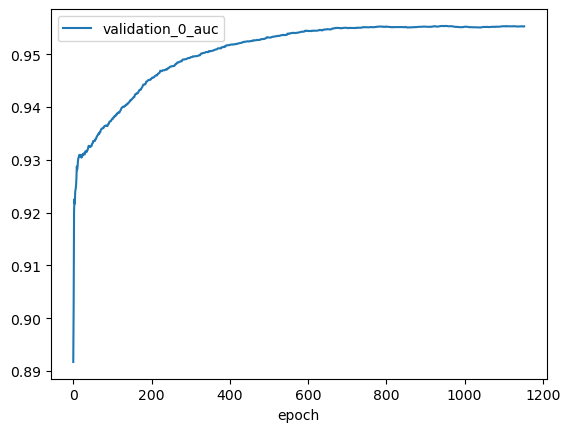

In [20]:
pd.DataFrame(model.callbacks[0].logs).set_index('epoch').plot()

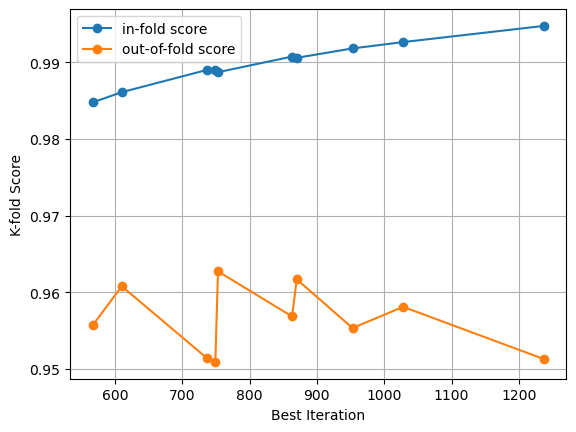

In [21]:
plt.plot(*kfold_results[['best_iter','tr_score']].sort_values('best_iter').values.T,'-o',label='in-fold score')
plt.plot(*kfold_results[['best_iter','score']].sort_values('best_iter').values.T,'-o',label='out-of-fold score')
plt.ylabel('K-fold Score')
plt.xlabel('Best Iteration')
plt.legend()
plt.grid()

In [22]:
average_feature_importances = pd.DataFrame(feature_importances,columns=Xtr.columns).mean(axis=0).sort_values(ascending=False)
average_feature_importances

loan_grade                    0.222758
person_home_ownership         0.193518
loan_percent_income           0.159041
loan_int_rate                 0.075975
person_income                 0.075092
loan_intent                   0.068473
cb_person_default_on_file     0.055006
loan_amnt                     0.047668
person_emp_length             0.035171
loantoincome                  0.034252
person_age                    0.018520
cb_person_cred_hist_length    0.014526
dtype: float32

### Hyper parameter tuning

### Train model on all data

In [25]:
Xtr = Xtrain.drop(columns=['id','loan_status','fold'])
ytr = ytrain

In [26]:
mdl.fit(Xtr, ytr, eval_set = [(Xtr, ytr)], verbose  = 0)

tr_score     = roc_auc_score(ytr.values.flatten(), mdl.predict_proba(Xtr)[:,1])
best_iter       = mdl.best_iteration

In [31]:
ytest = mdl.predict(Xtest.drop(columns=['id']))
Xtest['loan_status'] = ytest

In [32]:
ytest.mean()

np.float64(0.11570924343956213)

In [33]:
print(f"\n---> All available training data | Shapes = {Xtr.shape} {ytr.shape}",end="")
print(f"\n---> Training Score = {tr_score:.6f} | Best Iter = {best_iter}")


---> All available training data | Shapes = (58645, 12) (58645,)
---> Training Score = 0.999967 | Best Iter = 4999


In [34]:
test[['id','loan_status']].to_csv('submission.csv',index=False)